### Mobile Madness

In [227]:
import pandas as pd
import numpy as np
import statsmodels.api as sm  


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns

%matplotlib inline

#### Read in data and explore

In [228]:
df = pd.read_csv("../dataset/churn-bigml-20.csv")
df.head(3)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True


In [229]:
df.columns = ['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'churn']

In [230]:
df.churn.value_counts()  # inflated zero issue

False    572
True      95
Name: churn, dtype: int64

In [231]:
df.head(1)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False


In [68]:
# convert churn to boolean
df['churn'] = [1 if i == True else 0 for i in df['churn']]

In [69]:
# what do service call look like
df.customer_service_calls.value_counts()

1    236
2    151
0    142
3     81
4     33
5     17
6      5
8      1
7      1
Name: customer_service_calls, dtype: int64

In [70]:
# more high calls, more than two
df['high_service_calls'] = [1 if i > 2 else 0 for i in df['customer_service_calls']]

In [153]:
df.area_code.value_counts()

415    337
408    169
510    161
Name: area_code, dtype: int64

#### Engineer day charge per min

In [203]:
df['day_charge_per_minute'] = df['total_day_charge']/ df['total_day_minutes']

In [213]:
df[['total_day_charge', 'total_day_minutes', 'state', 
    'area_code', 'charge_per_minute']].sort_values('charge_per_minute', ascending=False).head(10)

,total_day_charge,total_day_minutes,state,area_code,charge_per_minute
537,8.76,51.5,DC,408,0.170097
241,5.97,35.1,PA,415,0.170085
83,10.12,59.5,TX,510,0.170084
338,9.32,54.8,TN,408,0.170073
253,14.20,83.5,MO,415,0.170060
398,12.04,70.8,WA,408,0.170056
367,15.56,91.5,ND,415,0.170055
574,16.58,97.5,NE,415,0.170051
324,16.58,97.5,VT,510,0.170051
417,14.25,83.8,NE,408,0.170048


In [232]:
df[['total_day_charge', 'state', 'area_code']].sort_values('total_day_charge', ascending=False).head(20)

,total_day_charge,state,area_code
203,56.83,DE,510
2,56.59,NY,415
35,55.51,TX,510
549,55.20,OR,415
175,54.83,SC,408
226,54.79,ME,408
146,53.65,MN,510
442,53.24,MS,510
104,52.77,LA,510
636,52.05,DC,408


In [23]:
df[(df['churn'] == 1) & (df['high_service_calls'] == 1)].shape

(34, 21)

#### Looking at churn by state

In [234]:
df_state = pd.DataFrame(df.groupby(['state']).agg({'churn': 'sum', 'customer_service_calls': 'sum',
                                                          'total_day_charge': 'sum', 'total_day_minutes': 'sum',
                                                         'account_length':'max'})).reset_index()
df_state.sort_values(['churn', 'customer_service_calls', 'state'], ascending=False).head(25)

,state,churn,customer_service_calls,total_day_charge,total_day_minutes,account_length
47,WA,4.0,30,573.71,3374.8,166
13,ID,4.0,30,556.01,3270.6,193
31,NJ,4.0,29,576.15,3389.0,197
26,MT,4.0,27,448.09,2635.7,143
37,OR,4.0,24,541.28,3183.9,166
4,CA,4.0,16,323.40,1902.4,158
15,IN,3.0,33,564.25,3319.1,141
25,MS,3.0,29,550.79,3239.9,189
48,WI,3.0,28,552.49,3249.9,165
34,NY,3.0,27,474.60,2791.8,209


#### Looking at churn by state and area code

In [221]:
df_state = pd.DataFrame(df.groupby(['state', 'area_code']).agg({'churn': 'sum', 'customer_service_calls': 'sum',
                                                          'total_day_charge': 'sum', 'total_day_minutes': 'sum',
                                                         'account_length':'count'})).reset_index()
df_state.sort_values(['churn', 'state', 'area_code'], ascending=False).head(20)

,state,area_code,churn,customer_service_calls,total_day_charge,total_day_minutes,account_length
108,OR,415,4,11,372.31,2190.0,11
38,ID,415,4,16,342.56,2015.0,11
143,WV,510,3,9,220.02,1294.2,7
113,RI,408,3,9,129.58,762.2,5
99,NY,415,3,16,272.20,1601.2,8
140,WI,510,2,12,223.71,1315.9,6
136,WA,415,2,15,291.96,1717.4,8
135,WA,408,2,9,131.09,771.1,5
126,TX,510,2,7,111.66,656.8,4
94,NM,415,2,27,346.92,2040.7,12


#### Looking at churn by area code

In [150]:
df_areacode = pd.DataFrame(df.groupby(['area_code']).agg({'churn': 'sum', 'customer_service_calls': 'sum',
                                                          'total_day_charge': 'sum', 'total_day_minutes': 'sum',
                                                         'account_length':'max'})).reset_index()
df_areacode.sort_values(['churn', 'customer_service_calls'], ascending=False)

,area_code,churn,customer_service_calls,total_day_charge,total_day_minutes,account_length
1,415,41,524,10393.94,61139.3,209
0,408,28,267,5040.82,29651.4,232
2,510,26,252,5083.34,29901.7,215


#### Plotting area code

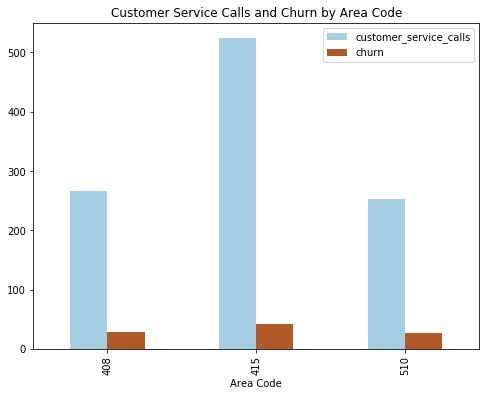

In [177]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
cmap = cm.get_cmap('Paired')

df_plot = df_areacode[['customer_service_calls','churn']]

ax = df_plot.plot(figsize=(8,6), kind='bar', colormap=cmap, fontsize=10)
ax.set_title('Customer Service Calls and Churn by Area Code', fontsize=12)
ax.set_xticks(range(len(df_areacode['area_code'])))
ax.set_xticklabels(df_areacode['area_code'], rotation='vertical', fontsize=10)
ax.set_xlabel('Area Code')
plt.show();

#### Plotting State Churn

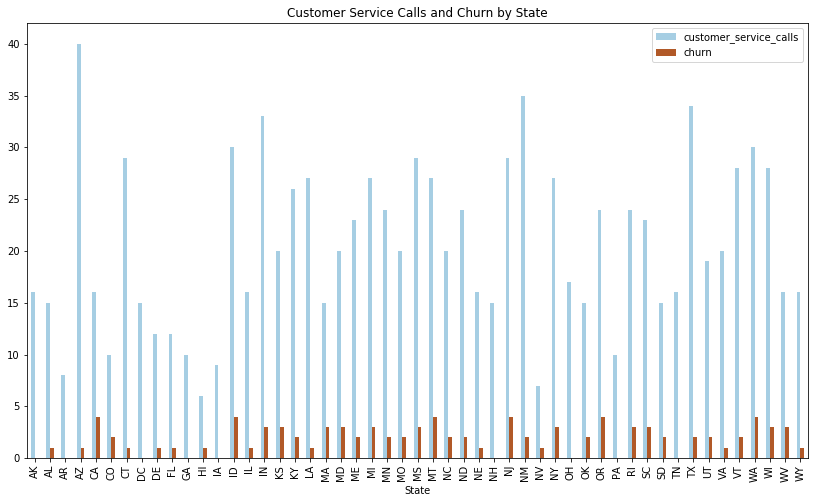

In [178]:

cmap = cm.get_cmap('Paired')

#df_state2 = pd.DataFrame(df.groupby(['state']).agg({'churn': 'sum', 'customer_service_calls': 'sum',
                                                         # 'total_day_charge': 'sum', 'total_day_minutes': 'sum',
                                                         #'account_length':'max'})).reset_index()
#df_state2.sort_values(['churn', 'customer_service_calls'], ascending=False).head(17)

df_plot2 = df_state[['customer_service_calls','churn']]

ax = df_plot2.plot(figsize=(14,8), kind='bar', colormap=cmap)
ax.set_title('Customer Service Calls and Churn by State')
ax.set_xticks(range(len(df_state['state'])))
ax.set_xticklabels(df_state['state'], rotation='vertical')
ax.set_xlabel('State')

plt.show();

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
cmap = cm.get_cmap('Paired')

df = df_mobile[['customer_service_calls','churn']]

ax = df.plot(kind='bar', colormap=cmap)
ax.set_title('Test')
ax.set_xticks(range(len(df_mobile['area_code'])))
ax.set_xticklabels(df_mobile['area_code'], rotation='vertical')

plt.show();

### Logistic Regression Modeling

In [107]:
# Baseline
baseline = df[df['churn'] == 0].shape[0] / df.shape[0]
print("Baseline=", round(baseline,2))
#df.shape[0]

Baseline= 0.86


In [128]:
df_mobile = df.copy()
lbl = preprocessing.LabelEncoder()
lbl.fit(list(df_mobile['state'].values))
df_mobile['state'] = lbl.transform(df_mobile['state'].values)
#test_model['Species'] = lbl.transform(test_model['Species'].values)

In [129]:
df_mobile.head(10)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,high_service_calls
0,18,117,408,No,No,0,184.5,97,31.37,351.6,...,29.89,215.8,90,9.71,8.7,4,2.35,1,0,0
1,15,65,415,No,No,0,129.1,137,21.95,228.5,...,19.42,208.8,111,9.40,12.7,6,3.43,4,1,1
2,34,161,415,No,No,0,332.9,67,56.59,317.8,...,27.01,160.6,128,7.23,5.4,9,1.46,4,1,1
3,40,111,415,No,No,0,110.4,103,18.77,137.3,...,11.67,189.6,105,8.53,7.7,6,2.08,2,0,0
4,11,49,510,No,No,0,119.3,117,20.28,215.1,...,18.28,178.7,90,8.04,11.1,1,3.00,1,0,0
5,0,36,408,No,Yes,30,146.3,128,24.87,162.5,...,13.81,129.3,109,5.82,14.5,6,3.92,0,0,0
6,22,65,415,No,No,0,211.3,120,35.92,162.6,...,13.82,134.7,118,6.06,13.2,5,3.56,3,0,1
7,13,119,415,No,No,0,159.1,114,27.05,231.3,...,19.66,143.2,91,6.44,8.8,3,2.38,5,1,1
8,45,10,408,No,No,0,186.1,112,31.64,190.2,...,16.17,282.8,57,12.73,11.4,6,3.08,2,0,0
9,48,68,415,No,No,0,148.8,70,25.30,246.5,...,20.95,129.8,103,5.84,12.1,3,3.27,3,0,1


In [246]:
X = df_mobile[['state', 'area_code', 'customer_service_calls', 'total_eve_charge', 'total_night_charge','total_day_charge']]
y = df_mobile['churn']# test/train off train dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [247]:

# test/train off train dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

ss = preprocessing.StandardScaler()
Xs_train = ss.fit_transform(X_train)

logreg1 = LogisticRegression()
logreg1.fit(Xs_train, y_train)

ss = preprocessing.StandardScaler()
Xs_test = ss.fit_transform(X_test)

score = logreg1.score(Xs_test, y_test)
cvs = cross_val_score(logreg1, Xs_test, y_test, cv=5).mean()

print('Baseline Accuracy:', baseline)
print('1st Logistic Regression Model Score:', score)
print('1st Logistic Regression 5 Folds Cross-Validation Score:', cvs)



Baseline Accuracy: 0.8575712143928036
1st Logistic Regression Model Score: 0.892215568862
1st Logistic Regression 5 Folds Cross-Validation Score: 0.910476190476


In [248]:
# From Remey to test with my features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# creating model for pipeline
model_cl = Pipeline([
    ('Standardization', StandardScaler()),
    ('RandomForestClassifier', RandomForestClassifier())
    ])
# Parameters for the RandomForestClassifier
param1 = {
    'RandomForestClassifier__n_estimators': [10, 20, 30],
    'RandomForestClassifier__criterion': ['gini', 'entropy'],
    'RandomForestClassifier__max_features': ['auto', 'log2', 'sqrt'],
    'RandomForestClassifier__n_jobs': [-1, 1]
        }
# Grid Search
grid_ = GridSearchCV(model_cl, param_grid = param1, verbose=1, n_jobs=-1)
grid_.fit(X_train, y_train)
# Best Score from the Random Forest Classifier
grid_.best_score_
# Best parameters from the Random Forest Classifier 
grid_.best_params_
# Best Estimator score from the Random Forest Classifier 
grid_.best_estimator_.score(X_test, y_test)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.7s finished


0.91017964071856283

In [249]:
import sklearn

model_cl.fit(X_train, y_train)
y_prediction = model_cl.predict(X_test)
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )
print(report)

             precision    recall  f1-score   support

          0       0.91      0.97      0.94       146
          1       0.64      0.33      0.44        21

avg / total       0.88      0.89      0.88       167

